<a href="https://colab.research.google.com/github/rainermesi/b_supply_analysis/blob/main/B_Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bolt - Supply Data Analysis

Import libraries and files

In [75]:
import pandas as pd
from pandas.tseries.offsets import DateOffset
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
activity_df = pd.read_excel('/content/drive/MyDrive/Bsda/Hourly_DriverActivity_1.csv.xlsx')
search_df = pd.read_excel('/content/drive/MyDrive/Bsda/Hourly_OverviewSearch_1.csv.xlsx')

Checking files and data quality. Joining activity and search tables into one.

In [9]:
merged_df = pd.merge(activity_df,search_df,on='Date',how='left')

In [10]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 840 entries, 0 to 839
Data columns (total 12 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Date                         840 non-null    object 
 1   Active drivers               840 non-null    int64  
 2   Online (h)                   840 non-null    int64  
 3   Has booking (h)              840 non-null    int64  
 4   Waiting for booking (h)      840 non-null    int64  
 5   Busy (h)                     840 non-null    int64  
 6   Hours per active driver      840 non-null    float64
 7   Rides per online hour        840 non-null    float64
 8   Finished Rides               795 non-null    float64
 9   People saw 0 cars (unique)   839 non-null    float64
 10  People saw +1 cars (unique)  839 non-null    float64
 11  Coverage Ratio (unique)      839 non-null    float64
dtypes: float64(6), int64(5), object(1)
memory usage: 85.3+ KB


### Calculating extra columns to produce required output

Renaming Online (h) as Supply and converting to minutes for precision

In [11]:
merged_df['Supply'] = merged_df['Online (h)'].apply(lambda x:x*60)

Calculating demand as total users multiplied by the average ride duration. I'm calculating avg ride duration by multiplying booked minutes by the number of finished rides.

In [12]:
merged_df['Has booking (m)'] = merged_df['Has booking (h)'].apply(lambda x:x*60)

In [13]:
merged_df['Avg ride duration (m)'] = merged_df.apply(lambda x: x['Has booking (m)'] / x['Finished Rides'],axis=1)

In [14]:
merged_df['Total users'] = merged_df.apply(lambda x: x['People saw 0 cars (unique)']+x['People saw +1 cars (unique)'],axis=1)

In [15]:
merged_df['Demand'] = merged_df.apply(lambda x: x['Total users'] * x['Avg ride duration (m)'],axis=1)

Calculating the supply ratio (supply / demand)

In [16]:
merged_df['Supply ratio'] = merged_df['Supply'].divide(merged_df['Demand'])

Calculating a column with a rolling average RPH. Window of 3 hours.

In [17]:
merged_df['Rolling avg RPH'] = merged_df['Rides per online hour'].rolling(3,min_periods=1).mean()

Calculating a column with guaranteed hourly earnings. Based on rollig RPH and average earning of €8 for the driver.

In [18]:
merged_df['Guaranteed earnings'] = merged_df['Rolling avg RPH'].apply(lambda x:x*8)

Calculating a column with the numberof extra hours needed to meet demand. Return 0 if supply already exceeds demand.

In [19]:
merged_df['Extra hours needed'] = merged_df.apply(lambda x: (x['Demand'] - x['Supply'])/60,axis=1)
merged_df['Extra hours needed'] = merged_df['Extra hours needed'].apply(lambda x: 0 if x < 0 else x)

## Output Tables and Graphs

1. Which 36 hours in a week are most undersupplied.

In [50]:
undersupply_ranked_table_df

Weekday,Friday,Monday,Saturday,Thursday,Tuesday,Wednesday
Hour,,,,,,
1,NaN,NaN,NaN,NaN,NaN,27.947691
2,NaN,NaN,NaN,13.076667,14.839135,NaN
3,37.196581,NaN,NaN,38.948944,NaN,6.400000
5,NaN,NaN,NaN,NaN,9.824599,5.459510
6,NaN,NaN,NaN,NaN,NaN,17.385698
7,NaN,NaN,NaN,25.531188,NaN,NaN
8,10.658285,9.678745,NaN,NaN,NaN,35.156744
9,NaN,11.007316,NaN,NaN,6.076923,NaN
10,NaN,11.764085,NaN,NaN,5.144444,NaN


2. 24-hour curve of average supply and demand (to illustrate match/mismatch).


Text(0.5, 1.0, 'Average Supply vs Demand over 24 hours')

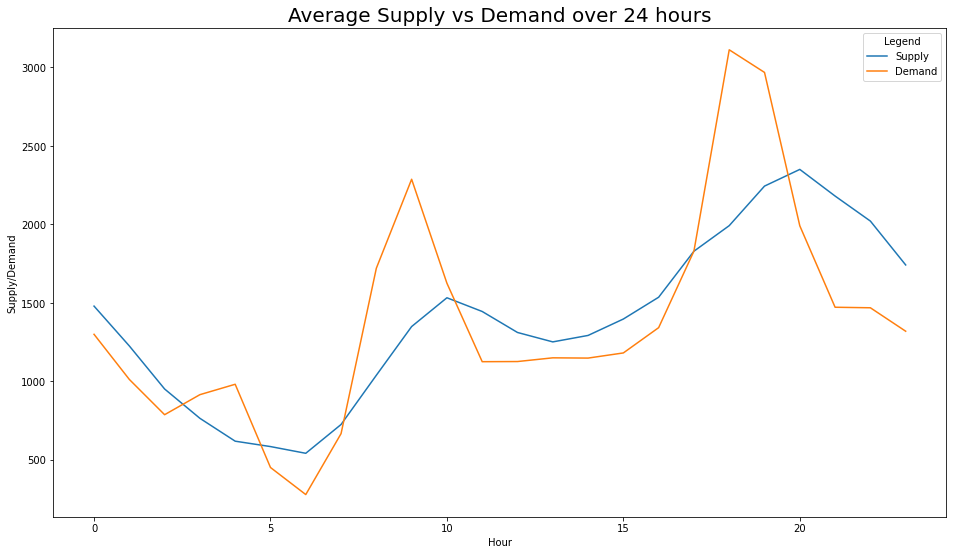

In [81]:
plt.figure(figsize = (16,9))
sns.lineplot(data = avg_supply_demand_df, 
             x='Hour',
             y='Supply/Demand',
             err_style='bars',
             hue='Legend'
             )
plt.title("Average Supply vs Demand over 24 hours", fontsize = 20)


3. Visualisation of hours where we lack supply during a weekly period.



Text(0.5, 1.0, 'Hours in week with high demand for drivers')

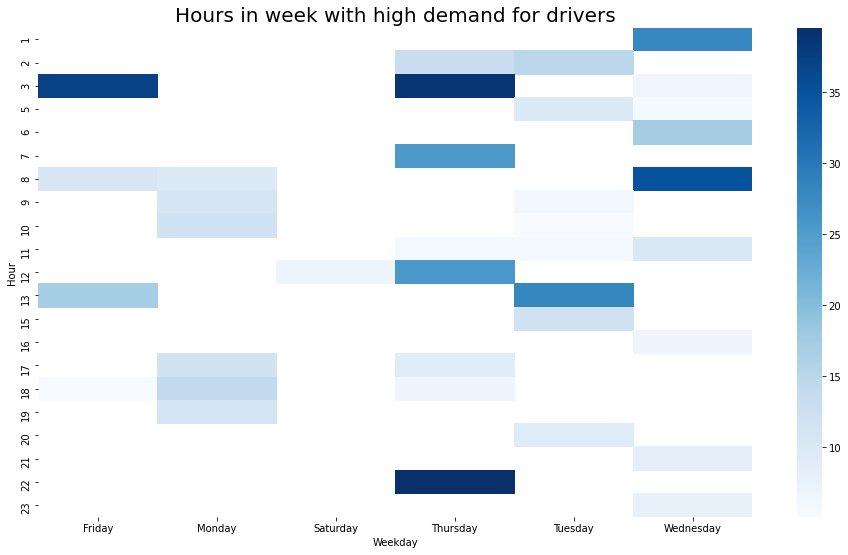

In [125]:
plt.figure(figsize = (16,9))

sns.heatmap(undersupply_ranked_table_df,annot=False,cmap='Blues')
plt.title("Hours in week with high demand for drivers", fontsize = 20)

4. Estimate number of hours needed to ensure we have a high Coverage Ratio during most peak hours.

In [137]:
merged_df[['Date','Supply ratio','Extra hours needed']].sort_values('Supply ratio',ascending=True).head(36)

,Date,Supply ratio,Extra hours needed
68,2016-12-16 03,0.155844,32.500000
56,2016-12-16 15,0.174330,66.307692
135,2016-12-13 08,0.179383,59.470588
52,2016-12-16 19,0.183333,147.000000
58,2016-12-16 13,0.192308,58.800000
55,2016-12-16 16,0.194245,74.666667
43,2016-12-17 04,0.206818,53.692308
38,2016-12-17 09,0.225806,24.000000
57,2016-12-16 14,0.237624,38.500000
101,2016-12-14 18,0.238095,86.400000


5. Calculate levels of guaranteed hourly earnings we can offer to drivers during 36 weekly hours with highest demand without losing money + how much extra hours we want to get to capture missed demand.

In [148]:
merged_df[['Date','Supply ratio','Extra hours needed','Guaranteed earnings']].sort_values('Supply ratio',ascending=True).head(36)

,Date,Supply ratio,Extra hours needed,Guaranteed earnings
68,2016-12-16 03,0.155844,32.500000,6.533333
56,2016-12-16 15,0.174330,66.307692,7.520000
135,2016-12-13 08,0.179383,59.470588,8.480000
52,2016-12-16 19,0.183333,147.000000,9.386667
58,2016-12-16 13,0.192308,58.800000,7.040000
55,2016-12-16 16,0.194245,74.666667,8.106667
43,2016-12-17 04,0.206818,53.692308,8.533333
38,2016-12-17 09,0.225806,24.000000,8.586667
57,2016-12-16 14,0.237624,38.500000,7.813333
101,2016-12-14 18,0.238095,86.400000,9.226667


undersupp

### Preparing the output tables and graphs

Top 36 undersupplied hours

In [102]:
undersupply_df = merged_df[['Date','Extra hours needed']]
undersupply_df['Datetime'] = pd.to_datetime(undersupply_df['Date'],format='%Y-%m-%d %H')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [103]:
undersupply_df = undersupply_df[['Datetime','Extra hours needed']]
undersupply_df.set_index('Datetime',inplace=True)

undersupply_ranked_df = (undersupply_df.groupby((undersupply_df.index.dayofweek + 1) * (undersupply_df.index.hour + 1))['Extra hours needed'].mean()
                        .rename_axis('HourOfWeek')
                        .reset_index()
                        )

undersupply_ranked_df['Datetime'] = undersupply_ranked_df.apply(lambda x: pd.Timestamp('2021-03-01 00:00:00') + DateOffset(hours=(x['HourOfWeek']-1)),axis=1)

undersupply_ranked_df['Weekday'] = undersupply_ranked_df['Datetime'].dt.day_name()
undersupply_ranked_df['Hour'] = undersupply_ranked_df['Datetime'].dt.hour

In [104]:
undersupply_ranked_table_df = undersupply_ranked_df.sort_values(by=['Extra hours needed'],ascending=False).head(36).reset_index()[['Weekday','Hour','Extra hours needed']].pivot(index='Hour',columns='Weekday',values='Extra hours needed')

24-hour curve of average supply and demand (to illustrate match/mismatch).


In [ ]:
avg_supply_demand_df = merged_df[['Date','Supply','Demand']]
avg_supply_demand_df['Hour'] = pd.to_datetime(avg_supply_demand_df['Date'],format='%Y-%m-%d %H').dt.hour
avg_supply_demand_df = avg_supply_demand_df[['Hour','Supply','Demand']]
avg_supply_demand_df = avg_supply_demand_df.groupby('Hour').mean().reset_index()

In [80]:
avg_supply = avg_supply_demand_df[['Hour','Supply']]
avg_supply['Legend'] = 'Supply'
avg_supply.rename(columns={'Supply':'Supply/Demand'}, inplace=True)
avg_demand = avg_supply_demand_df[['Hour','Demand']]
avg_demand['Legend'] = 'Demand'
avg_demand.rename(columns={'Demand':'Supply/Demand'}, inplace=True)
avg_supply_demand_df = avg_supply.append(avg_demand)